In [2]:
ENSEMBLE_LOGS_ROOT = "/h/pwilson/projects/TRUSnet/projects/IJCARS_2023/outputs/ensemble_fold_nocal1/2023-05-11_23-32-07"
import os 
seed_dirs = os.path.join(ENSEMBLE_LOGS_ROOT, 'seed_*')
import glob
seed_dirs = glob.glob(seed_dirs)
import pandas as pd
import torch 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score
import skimage

In [3]:
def load_best_model_checkpoint(exp_dir):
    metrics = pd.read_csv(os.path.join(exp_dir, 'metrics.csv'))
    best_epoch = metrics['val/core_auc'].idxmax() + 1
    checkpoint = torch.load(os.path.join(exp_dir, 'checkpoints', f'epoch_{best_epoch}', 'model.pth'))
    print(f'Loaded best model from epoch {best_epoch}')
    return checkpoint

In [4]:
from trusnet.modeling.registry import resnet10
models = {}
for seed_dir in seed_dirs:
    seed = int(seed_dir.split('_')[-1])
    models[seed] = resnet10()
    models[seed].cuda()
    models[seed].eval()
    models[seed].load_state_dict(load_best_model_checkpoint(seed_dir))

Loaded best model from epoch 5
Loaded best model from epoch 2
Loaded best model from epoch 6
Loaded best model from epoch 6
Loaded best model from epoch 5
Loaded best model from epoch 8
Loaded best model from epoch 3
Loaded best model from epoch 8
Loaded best model from epoch 5
Loaded best model from epoch 2


In [5]:
import torch 

class Ensemble(torch.nn.Module):
    def __init__(self, models):
        super().__init__()
        self.models = torch.nn.ModuleList(models)

    def forward(self, X):
        return torch.mean(torch.stack([model(X) for model in self.models], dim=0), dim=0)
    
ensemble = Ensemble(list(models.values()))

In [6]:
ensemble.eval().cuda()

Ensemble(
  (models): ModuleList(
    (0-9): 10 x ResNet(
      (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (layer2): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1

In [7]:
from trusnet.data.exact.nct02079025 import cohort_selection



In [8]:
from trusnet.data.exact.nct02079025.core import Core

In [9]:
core = Core.sample_core()

/ssd003/home/pwilson/projects/TRUSnet/trusnet/data/exact/nct02079025/core.py:222: UserWarning: You appear to be calling Core constructor manually. It is preferable to call `Core.create_core(specifier)`
                    which will cache core instances and not double memory requirements for core objects!
                
  warn(


In [10]:
from projects.IJCARS_2023.src.dataset_factory import create_datasets, add_dataset_args
from argparse import ArgumentParser
parser = ArgumentParser()
add_dataset_args(parser)
args = parser.parse_args([])
args.fold = 1
args.n_folds = 10
print(args)
args.add_ood_dataset = True
train_ds, val_ds, test_ds, ood_ds = create_datasets(args)

Namespace(keep_low_involvement_cores_for_evaluation=False, benign_undersampling_kfold=None, augmentations_mode='none', fold=1, n_folds=10, add_ood_dataset=False, normalization='instance')


Loading Cores: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 726/726 [00:10<00:00, 68.18it/s]


Failed to load 3/726 cores: ['PMCC-0027_RBM', 'PMCC-0182_LML', 'PMCC-0027_LAM']


Loading Cores: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1115/1115 [00:11<00:00, 93.50it/s]


Failed to load 11/1115 cores: ['PMCC-0033_LBM', 'PMCC-0033_RAL', 'PMCC-0033_LAM', 'PMCC-0033_LMM', 'PMCC-0033_RBM', 'PMCC-0033_RML', 'PMCC-0033_RAM', 'PMCC-0033_RMM', 'PMCC-0033_RBL', 'PMCC-0033_LBL', 'PMCC-0033_LML']


Loading Cores: 100%|████████████████████████████████████████████████████████████████████████████████████████| 654/654 [00:06<00:00, 100.33it/s]


Failed to load 20/654 cores: ['CRCEO-0009_LAM', 'CRCEO-0009_LML', 'CRCEO-0009_RAM', 'PMCC-0036_RMM', 'CRCEO-0009_LAL', 'CRCEO-0070_LAM', 'PMCC-0036_LAL', 'PMCC-0036_LBM', 'PMCC-0036_LML', 'PMCC-0036_RAL', 'PMCC-0036_RAM', 'PMCC-0036_RBL', 'PMCC-0036_RML', 'CRCEO-0009_RAL', 'CRCEO-0342_RAL', 'PMCC-0036_LBL', 'PMCC-0036_LMM', 'CRCEO-0342_RAM', 'PMCC-0036_LAM', 'PMCC-0036_RBM']


Loading Cores: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:01<00:00, 65.88it/s]

Failed to load 3/115 cores: ['PMCC-0036_LAL', 'PMCC-0036_LBM', 'PMCC-0036_RMM']


In [11]:
from trusnet.utils.accumulators import DictConcatenation
torch.multiprocessing.set_sharing_strategy('file_system')
from tqdm import tqdm

def get_predictions(ds):
    acc = DictConcatenation()
    for batch in tqdm(torch.utils.data.DataLoader(ds, batch_size=32, num_workers=4, shuffle=False)):
        patch = batch.pop('patch').cuda()
        out = ensemble(patch)
        probs = out.softmax(dim=1)
        acc({
            'prob': probs, 
            **batch
        })

    return acc.compute('dataframe')

val_df = get_predictions(val_ds)
test_df = get_predictions(test_ds)    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1090/1090 [03:38<00:00,  4.98it/s]


<Axes: >

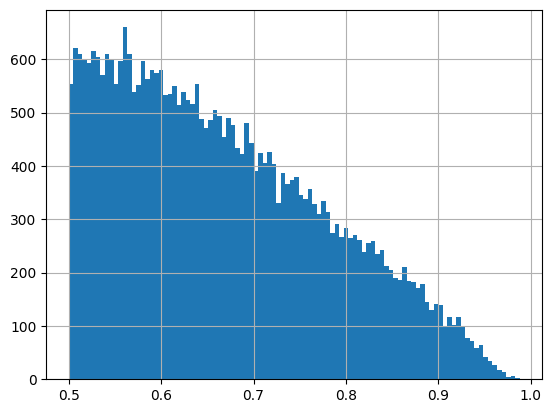

In [46]:
prob = test_df['prob_1'].values
mps = np.max(np.stack([prob, 1 - prob], axis=1), axis=1)
test_df['mps'] = mps
test_df.mps.hist(bins=100)

In [17]:
from trusnet.utils.calibration import compute_temperature_and_bias_for_calibration

prob = torch.tensor(val_df.prob_1.values)
y = torch.tensor(val_df.label.values)

temp, bias = compute_temperature_and_bias_for_calibration(prob, y)

In [19]:
from trusnet.data.exact.nct02079025.server.segmentation import list_available_prostate_segmentations

cores_for_heatmaps = [core for core in test_ds.cores if core.specifier in list_available_prostate_segmentations()]
pure_benign_cores = [core for core in cores_for_heatmaps if core.get_patient_object().all_cores_are_benign]
cancer_cores = [core for core in cores_for_heatmaps if core.metadata['grade'] != "Benign"]

In [20]:
cancer_cores

In [21]:
CLEAR_BENIGN_CORE = cores_for_heatmaps[57]
TRICKY_BENIGN_CORE = pure_benign_cores[28]

In [22]:
import skimage

def preprocess_bmode(bmode):
    bmode = skimage.exposure.rescale_intensity(bmode, out_range=(0, 1))
    bmode = np.flip(bmode, axis=0)
    bmode = bmode * 255
    bmode = bmode.astype(np.uint8)
    bmode = skimage.exposure.adjust_gamma(bmode, 1.5)
    from trusnet.data.transforms import adjust_tgc
    bmode = adjust_tgc(bmode, [1, 1, 1, 1, 1.1, 1.2, 1.3, 1.4])
    bmode = skimage.exposure.adjust_gamma(bmode, gain=1.2)
    bmode = skimage.transform.resize(bmode, (28 * 32, 46 * 32))
    bmode = skimage.color.gray2rgb(bmode)
    bmode = np.flip(bmode, axis=0)
    return bmode


In [23]:
hmap = CLEAR_BENIGN_CORE.create_heatmap(ensemble, test_ds.patch_transform, compute_device='cuda')


In [29]:
from trusnet.utils.calibration import apply_temperature_and_bias
H, W = hmap.shape
hmap = hmap.reshape(-1)
hmap = apply_temperature_and_bias(hmap, temp, bias)
hmap = hmap.reshape(H, W)

In [94]:
transform = test_ds.patch_transform
core = CLEAR_BENIGN_CORE
compute_device = 'cuda'
compute_batch_size = 128
model = ensemble


def create_heatmap(core, model, transform, temp=None, bias=None, compute_device='cuda', compute_batch_size=128, mps_threshold=0.6, bmode_transp=0.8, pred_transp=0.02):

    bmode = preprocess_bmode(core.bmode)
    bmode *= bmode_transp
    prostate_mask = core.prostate_mask 
    
    import torch
    from itertools import product
    from trusnet.data.image_utils import sliding_window_slice_coordinates

    x, y = sliding_window_slice_coordinates((5, 5), (1, 1), (28, 46))

    # extract patches from core
    patches = []
    patch_indices = []
    for i, j in product(range(len(x)), range(len(y))):
        X = core.get_patch(x[i][0], x[i][1], y[j][0], y[j][1])
        X = transform(X)
        patches.append(X)
        patch_indices.append((x[i][0], x[i][1], y[j][0], y[j][1]))

    patches = torch.stack(patches).to(compute_device)

    # get predictions for patches
    preds = []
    with torch.no_grad():
        for batch in torch.utils.data.DataLoader(
            patches, batch_size=compute_batch_size
        ):
            batch = batch.to(compute_device)
            probs = model(batch).softmax(dim=-1)
            preds.append(probs)

        preds = torch.cat(preds)

    preds = preds[:, 1].cpu().numpy()
    if temp is not None and bias is not None:
        preds = apply_temperature_and_bias(preds, temp, bias)

    from itertools import product
    from trusnet.data.image_utils import convert_physical_coordinate_to_pixel_coordinate

    prostate_mask = skimage.transform.resize(prostate_mask, (28 * 32, 46 * 32))

    for pred, patch_index in zip(preds, patch_indices):
        i1, i2, j1, j2 = patch_index
        x1, y1 = convert_physical_coordinate_to_pixel_coordinate((i1, j1), (28, 46), (0, 0), (28 * 32, 46 * 32))
        x1 = int(x1)
        y1 = int(y1)
        x2, y2 = convert_physical_coordinate_to_pixel_coordinate((i2, j2), (28, 46), (0, 0), (28 * 32, 46 * 32))
        x2 = int(x2)
        y2 = int(y2)
        if prostate_mask is not None and prostate_mask[x1:x2, y1:y2].mean() < 0.5:
            continue
        if pred > mps_threshold: 
            bmode[x1:x2, y1:y2, 0] += 0.02
        elif 1 - pred > mps_threshold: 
            bmode[x1:x2, y1:y2, 2] += 0.02

    return np.flip(bmode, 0)


class HeatMapGenerator: 
    def __init__(self, model, compute_device='cuda', compute_batch_size=128, temp=None, bias=None):
        self.model = model
        self.compute_device = compute_device
        self.compute_batch_size = compute_batch_size
        self.temp = temp
        self.bias = bias

    def compute(self, core, transform):
        import torch
        from itertools import product
        from trusnet.data.image_utils import sliding_window_slice_coordinates

        x, y = sliding_window_slice_coordinates((5, 5), (1, 1), (28, 46))

        # extract patches from core
        patches = []
        self.patch_indices = []
        for i, j in product(range(len(x)), range(len(y))):
            X = core.get_patch(x[i][0], x[i][1], y[j][0], y[j][1])
            X = transform(X)
            patches.append(X)
            self.patch_indices.append((x[i][0], x[i][1], y[j][0], y[j][1]))

        patches = torch.stack(patches).to(compute_device)
        # get predictions for patches
        preds = []
        with torch.no_grad():
            for batch in torch.utils.data.DataLoader(
                patches, batch_size=self.compute_batch_size
            ):
                batch = batch.to(self.compute_device)
                probs = self.model(batch).softmax(dim=-1)
                preds.append(probs)

            preds = torch.cat(preds)

        preds = preds[:, 1].cpu().numpy()
        if self.temp is not None and self.bias is not None:
            self.preds = apply_temperature_and_bias(preds, self.temp, self.bias)

    def render(self, core, mps_threshold=0.6, bmode_transp=0.8, pred_transp=0.02):
        bmode = preprocess_bmode(core.bmode)
        bmode *= bmode_transp
        prostate_mask = core.prostate_mask 

        from itertools import product
        from trusnet.data.image_utils import convert_physical_coordinate_to_pixel_coordinate

        prostate_mask = skimage.transform.resize(prostate_mask, (28 * 32, 46 * 32))

        for pred, patch_index in zip(self.preds, self.patch_indices):
            i1, i2, j1, j2 = patch_index
            x1, y1 = convert_physical_coordinate_to_pixel_coordinate((i1, j1), (28, 46), (0, 0), (28 * 32, 46 * 32))
            x1 = int(x1)
            y1 = int(y1)
            x2, y2 = convert_physical_coordinate_to_pixel_coordinate((i2, j2), (28, 46), (0, 0), (28 * 32, 46 * 32))
            x2 = int(x2)
            y2 = int(y2)
            if prostate_mask is not None and prostate_mask[x1:x2, y1:y2].mean() < 0.9:
                continue
            if pred > mps_threshold: 
                bmode[x1:x2, y1:y2, 0] += 0.02
            elif 1 - pred > mps_threshold: 
                bmode[x1:x2, y1:y2, 2] += 0.02

        return np.flip(bmode, 0)

    

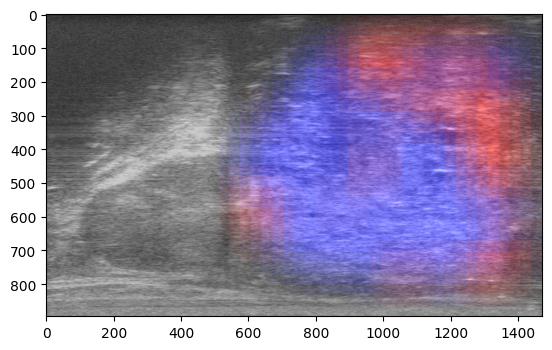

In [95]:
hmap_gen = HeatMapGenerator(model, compute_device='cuda', compute_batch_size=128, temp=temp, bias=bias)
hmap_gen.compute(pure_benign_cores[1], transform)
hmap = hmap_gen.render(pure_benign_cores[1], mps_threshold=0.5, bmode_transp=0.8, pred_transp=0.02)
plt.imshow(hmap)

In [96]:
mps = test_df.mps.values
quantiles = np.quantile(mps, [0, 0.20, .40, .60])

def plot_for_core(core):

    hmap_gen = HeatMapGenerator(model, compute_device='cuda', compute_batch_size=128, temp=temp, bias=bias)
    hmap_gen.compute(core, transform)
    # hmap = hmap_gen.render(pure_benign_cores[1], mps_threshold=0.5, bmode_transp=0.8, pred_transp=0.02)
    # plt.imshow(hmap)

    hmaps = []
    for i in range(len(quantiles)):
        hmaps.append(hmap_gen.render(core, mps_threshold=quantiles[i], bmode_transp=0.8, pred_transp=0.02 * (i+1)))

    fig, ax = plt.subplots(1, 1+len(quantiles), figsize=(20, 5))
    extent = (0, 46, 0, 28)
    bmode = np.flip(core.bmode, 0)
    needle_mask = np.flip(core.needle_mask, 0)
    prostate_mask = np.flip(core.prostate_mask, 0)
    ax[0].imshow(bmode, extent=extent, cmap='gray')
    ax[0].imshow(prostate_mask, extent=extent, cmap='Purples', alpha=0.3 * prostate_mask)
    ax[0].imshow(needle_mask, extent=extent, alpha=0.5 * needle_mask)

    for i in range(len(quantiles)):
        ax[1+i].imshow(hmaps[i], extent=extent)

    [ax.set_axis_off() for ax in ax]
    plt.tight_layout()

for core in cores_for_heatmaps:
    plot_for_core(core)
    plt.savefig(os.path.join('/ssd005/projects/exactvu_pca/outputs', f'{core.specifier}-{core.metadata["grade"]}.png'))
    plt.close()


In [52]:
quantiles

array([0.50001329, 0.59517636, 0.7086511 ])

In [ ]:
cores_for_heatmaps

(0.0, 46.0, 0.0, 28.0)

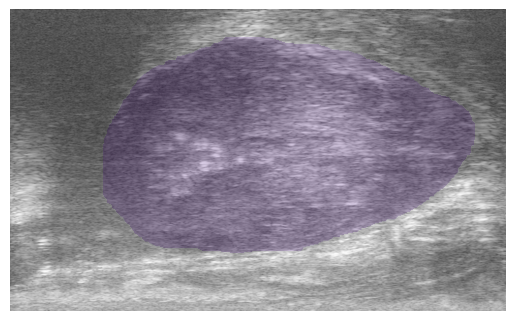

In [ ]:
IDX = 0
bmode = cancer_cores[IDX].bmode
bmode = preprocess_bmode(bmode)
prostate_mask = cancer_cores[IDX].prostate_mask
prostate_mask = np.flip(prostate_mask, axis=0)
plt.imshow(np.flip(bmode, axis=0), extent=[0, 46, 0, 28])
plt.imshow(prostate_mask, extent=[0, 46, 0, 28], alpha=0.2 * prostate_mask, cmap='Purples')
plt.axis('off')


In [ ]:
28 * 64

1792

In [ ]:
from sk

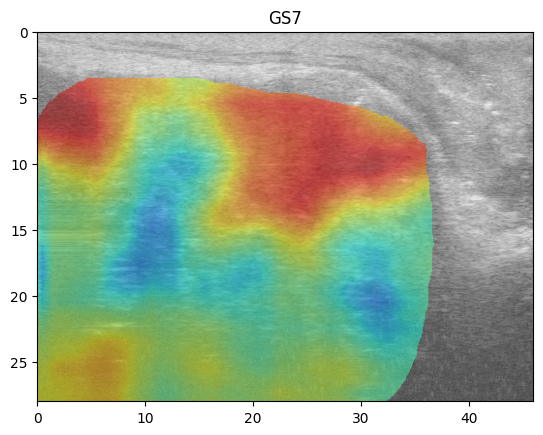

In [ ]:

IDX = 12

EXTENT=[0, 46, 28, 0]

core = cancer_cores[IDX]
import matplotlib.pyplot as plt
plt.imshow(core.bmode, cmap='gray', extent=EXTENT)
plt.title(core.metadata['grade'])

hmap = core.create_heatmap(ensemble, test_ds.patch_transform, compute_device='cuda')
from skimage.transform import resize
hmap = resize(hmap, (512, 512))
prst_mask = resize(core.prostate_mask, (512, 512))
plt.imshow(hmap, cmap='jet', aspect='auto', vmin=0, vmax=1, alpha=0.5 * prst_mask, extent=EXTENT)

In [3]:
from torchvision import transforms as T
T.Resize(512)

Resize(size=512, interpolation=bilinear, max_size=None, antialias=warn)